In [1]:
import os
import sys

import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import time
import math

def time_since(since):
	s = time.time() - since
	m = math.floor(s/60)
	s -= m*60
	return '%dm %ds' % (m, s)


CONTEXT_SIZE = 2 
EMBEDDING_DIM = 10


In [2]:
modelPath = "4_test.pkl"
argPath = '4_testArg.pt'
test_sentence = "當地警察已在28日下午開始監控人潮，但遊客數量似乎不如預期的多，因為當局目前認定還沒有關閉閘門的必要。威尼斯絡繹不絕的觀光客，已經成為當地人的惡夢。當地巷弄窄小，在旅遊旺季街道幾乎難以行走。"

trigrams = []
trigramsList = []
trigramsList = [ ([test_sentence[i], test_sentence[i+1]], test_sentence[i+2])
            for i in range(len(test_sentence) - 2) ]

vocab = set(test_sentence)

word_to_ix = {word : i for i, word in enumerate(vocab)}
ix_to_word = {i: word for i, word in enumerate(vocab)}

In [3]:
len(vocab)

74

In [4]:
class NGramLanguageModeler(nn.Module):

    def __init__(self, vocab_size, embedding_dim, context_size):
        super(NGramLanguageModeler, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear1 = nn.Linear(context_size * embedding_dim, 128)
        self.linear2 = nn.Linear(128, vocab_size)

    def forward(self, inputs):
        embdeds = self.embeddings(inputs).view((1, -1))
        out = F.relu(self.linear1(embdeds))
        out = self.linear2(out)
        log_probs = F.log_softmax(out, dim=1)
        return log_probs, self.embeddings

model = NGramLanguageModeler(len(vocab), EMBEDDING_DIM, CONTEXT_SIZE)
losses = []
loss_function = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01, eps = 0.1, betas=(0.99, 0.999))
#optimizer = optim.SGD(model.parameters(), lr=0.001)

In [5]:
# loading pretrained model, etc...
print('loading pretrained model...')
"""
checkpoint = torch.load(argPath)
#args.start_epoch = checkpoint['epoch']
model.load_state_dict(checkpoint['state_dict'])
optimizer.load_state_dict(checkpoint['optimizer'])
print("=> loaded checkpoint : (epoch {})".format(checkpoint['epoch']))
"""

loading pretrained model...


'\ncheckpoint = torch.load(argPath)\n#args.start_epoch = checkpoint[\'epoch\']\nmodel.load_state_dict(checkpoint[\'state_dict\'])\noptimizer.load_state_dict(checkpoint[\'optimizer\'])\nprint("=> loaded checkpoint : (epoch {})".format(checkpoint[\'epoch\']))\n'

In [6]:
if torch.cuda.is_available():
    print("in gpu")
    model.cuda()
else:
    print("in cpu")
    model.cpu()

in cpu


In [7]:
start_time = time.time()
for epoch in range(1000):
    total_loss = torch.FloatTensor([0])
    
    #for trigramsItem in trigramsList:
    for context, target in trigramsList:
            # step 1:
            # �Ncontext(ex : ['When','forty'])�ഫ��index(ex : [68, 15])
            # �A�নpytorch��variable
        context_idxs = [word_to_ix[w] for w in context]
        context_var = autograd.Variable(torch.LongTensor(context_idxs))

            # step 2:
            # �M��gradient�A����W�@�����֭p
        model.zero_grad()

            # step 3:
            # ��variable�ܼƶi�h�]forward
        log_probs, embedd = model(context_var)

            # step 4:
            # �p��loss(��target variable��i�h)
        loss = loss_function(log_probs, autograd.Variable(torch.LongTensor([word_to_ix[target]])))
        """
        print(log_probs)
        print(autograd.Variable(torch.cuda.LongTensor([word_to_ix[target]])))
        print(loss)
        print('-----------------------------------')
        """
            # step 5:
            # �]backward�A��sgradient
        loss.backward()
        optimizer.step()

        total_loss += loss.data
    losses.append(total_loss)
        #losses.append(total_loss)
    
    if epoch % 100 == 0:
        print('epoch:')
        print(epoch)
        print(time_since(start_time))
        print('loss:')
        print(total_loss[0])
        sentence = ['當','局']
        predict_word = ''
        count = 0

        while count < 50 :
            word_in = autograd.Variable(torch.LongTensor([word_to_ix[i] for i in sentence[len(sentence)-2:len(sentence)]]))
            out, outEmbedd = model(word_in)
            _, predict_label = torch.max(out,1)
            predict_word = ix_to_word[predict_label.data[0].item()]
            #sentence.insert(0, predict_word)
            sentence.append(predict_word)
            count += 1
        print(sentence)
        sentence = []
print("training time : ",time_since(start_time))

epoch:
0
0m 0s
loss:
tensor(407.7391)
['當', '局', '2', '8', '人', '下', '乎', '人', '光', '。', '的', '乎', '，', '察', '的', '2', '日', '在', '2', '8', '人', '下', '乎', '人', '光', '。', '的', '乎', '，', '察', '的', '2', '日', '在', '2', '8', '人', '下', '乎', '人', '光', '。', '的', '乎', '，', '察', '的', '2', '日', '在', '2', '8']
epoch:
100
0m 5s
loss:
tensor(5.5251)
['當', '局', '目', '前', '認', '定', '還', '沒', '有', '關', '閉', '閘', '門', '的', '必', '要', '。', '威', '尼', '斯', '絡', '繹', '不', '絕', '的', '觀', '光', '客', '，', '已', '經', '成', '為', '當', '地', '人', '的', '惡', '夢', '。', '當', '地', '人', '的', '惡', '夢', '。', '當', '地', '人', '的', '惡']
epoch:
200
0m 11s
loss:
tensor(5.2207)
['當', '局', '目', '前', '認', '定', '還', '沒', '有', '關', '閉', '閘', '門', '的', '必', '要', '。', '威', '尼', '斯', '絡', '繹', '不', '絕', '的', '觀', '光', '客', '，', '已', '經', '成', '為', '當', '地', '人', '的', '惡', '夢', '。', '當', '地', '人', '的', '惡', '夢', '。', '當', '地', '人', '的', '惡']
epoch:
300
0m 16s
loss:
tensor(5.1022)
['當', '局', '目', '前', '認', '定', '還', '沒', '有', '關', '閉', '閘', '門

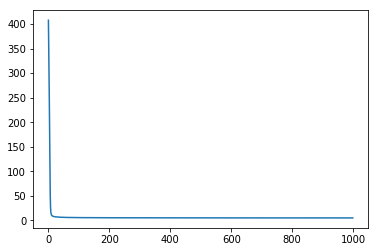

In [8]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

%matplotlib inline
plt.figure
plt.plot(losses)

In [9]:

"""
print('saving model...')
torch.save(model, '0_test.pkl')
state = {
    'epoch': 10,
    'state_dict': model.state_dict(),
    'optimizer' : optimizer.state_dict()
}
torch.save(state, '0_testArg.pt')
"""

### predict
print('saving done & predicting...')

sentence = ['當','局']
predict_word = ''
count = 0

while count < 50 :
    word_in = autograd.Variable(torch.LongTensor([word_to_ix[i] for i in sentence[len(sentence)-2:len(sentence)]]))
    out, outEmbedd = model(word_in)
    _, predict_label = torch.max(out,1)
    predict_word = ix_to_word[predict_label.data[0].item()]
    #sentence.insert(0, predict_word)
    sentence.append(predict_word)
    count += 1
print(sentence)
sentence = []

saving done & predicting...
['當', '局', '目', '前', '認', '定', '還', '沒', '有', '關', '閉', '閘', '門', '的', '必', '要', '。', '威', '尼', '斯', '絡', '繹', '不', '絕', '的', '觀', '光', '客', '，', '已', '經', '成', '為', '當', '地', '人', '的', '惡', '夢', '。', '當', '地', '人', '的', '惡', '夢', '。', '當', '地', '人', '的', '惡']
